# Notebook 2
## Coral data presentation for neighboring corals

This notebook, takes a look at the corals from Solomon, Timor Leste and Indonesia, once it was decided to add them to the data set 

In [1]:
# Import useful packages

import gdal
import pandas as pd
import geopandas as gpd
from io import StringIO
import osr
import matplotlib.pyplot as plt
import pandas as pd
import rtree
import pygeos
import os, json
import geopandas as gpd
from ipywidgets import widgets
from ipyleaflet import Map, GeoData, basemaps, LayersControl, ScaleControl, FullScreenControl, WidgetControl
from ipywidgets import widgets, IntSlider, jslink
import numpy as np

import sys
sys.path.insert(0, os.path.abspath(''))

import practical_functions as pf
import data_processing_helper as dp


import seaborn as sns
#bokeh
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

# Load image from local storage
from IPython.display import Image

from ipyleaflet import *

/home/lavinia/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Import the csv data with percentage of hard, soft corals, other inverterbrates and other things 
Survey_global = pd.read_csv("../Data/Reefs/seaviewsurvey_surveys.csv")
Survey_global.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


We will add neighbouring surveys such as:
- Indonesia : 114 --> IDN
- Timore Leste: 26 --> TLS
- Solomon: 20 --> SLB

In [3]:
Survey_AUS = Survey_global[(Survey_global["country"] == "AUS")]

In [4]:
Survey = Survey_global[(Survey_global["country"] == "AUS") | (Survey_global["country"] == "IDN") | (Survey_global["country"] == "TLS")| (Survey_global["country"] == "SLB")]
print("We now have a total of :",Survey.shape[0], " Surveys")
Survey.head()

We now have a total of : 421  Surveys


,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [5]:

# Make the integers "surveydate" as a real time frame 
Survey['surveydate'] = pd.to_datetime(Survey['surveydate'], format='%Y%m%d')
Survey.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,2012-09-16,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,2012-09-17,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,2012-09-18,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,2012-09-20,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,2012-09-20,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


<AxesSubplot:>

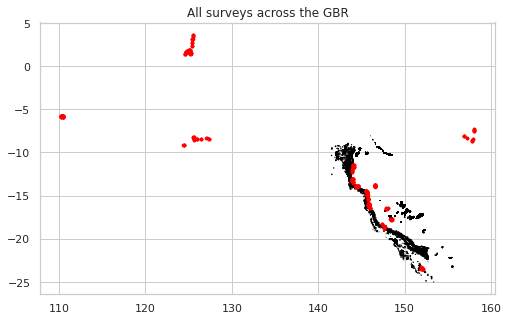

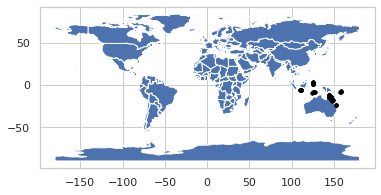

In [6]:
# Map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
Survey_end = Survey.copy()
# Data frame with start survey coordinates as geometric points 
gSurvey = gpd.GeoDataFrame(Survey, geometry = gpd.points_from_xy(Survey.lng_start, Survey.lat_start))

gSurvey_end = gpd.GeoDataFrame(Survey_end, geometry = gpd.points_from_xy(Survey.lng_end, Survey.lat_end))

# Map of GBR
shx = gpd.read_file("../Data/Reefs/shp_GBR/Reefs_GBR.shx")
ax = shx.plot(figsize=(15, 5), edgecolor='black')
ax.set_title("All surveys across the GBR")

# Plot the survey points on the GBR map
gSurvey.plot(ax = ax, color = 'red',markersize=7)

# Plot the survey points on the world map
ax_world = world.plot()
gSurvey.plot(ax = ax_world, color = 'black',markersize=7)

In [7]:
# Take the mean of the percentage cover for the whole dataframe 

mean_hard_coral = pf.mean_col(Survey, "pr_hard_coral")
mean_soft_coral = pf.mean_col(Survey, "pr_soft_coral")
mean_algae_coral = pf.mean_col(Survey, "pr_algae")
mean_oth_inv_coral = pf.mean_col(Survey, "pr_oth_invert")
mean_oth_coral = pf.mean_col(Survey, "pr_other")
mean_spec = pd.DataFrame({'Mean': [mean_hard_coral, mean_soft_coral, mean_algae_coral, mean_oth_inv_coral, mean_oth_coral]},index=["pr_hard_coral", "pr_soft_coral","pr_algae", "pr_oth_invert", "pr_other"])

###### Plot the means as pie plot 

<AxesSubplot:ylabel='Mean'>

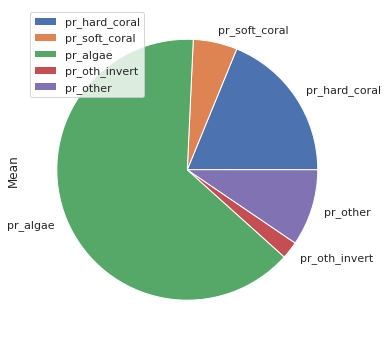

In [8]:
mean_spec.plot.pie(y = "Mean", figsize=(11, 6))

###### Number of surveys per year

In [9]:
Survey["surveydate"].dt.year.value_counts().reset_index()

,index,surveydate
0,2014,163
1,2012,118
2,2016,60
3,2018,45
4,2017,35


In [10]:
Survey["year"] = Survey["surveydate"].dt.year

Text(0.5, 1.0, 'Number of survey depending on year and country')

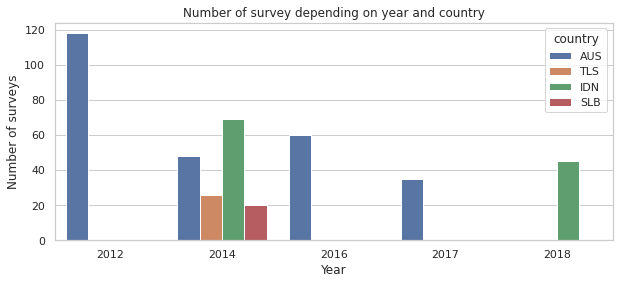

In [11]:
plt.figure(figsize = (10,4))
fig = sns.countplot(x = Survey["year"], hue = Survey["country"])
plt.ylabel("Number of surveys")
plt.xlabel("Year")
plt.title("Number of survey depending on year and country")

We note that the number of surveys in 2014 were the highest.

In [12]:
# Split the data frames based on the years
Survey_2012, Survey_2014, Survey_2016, Survey_2017, Survey_2018= pf.split_years(Survey)


###### Make a Geodata-frame with the survey points

In [13]:
gSurvey_2012 = pf.make_geo_frame(Survey_2012)
gSurvey_2014 = pf.make_geo_frame(Survey_2014)
gSurvey_2016 = pf.make_geo_frame(Survey_2016)
gSurvey_2017 = pf.make_geo_frame(Survey_2017)
gSurvey_2018 = pf.make_geo_frame(Survey_2018)


In [14]:
# Look if any transectid (square) has several surveys in it 
print("Survey_2012: = ",pf.trans_surv(gSurvey_2012)[0])
print("Survey_2014: = ",pf.trans_surv(gSurvey_2014)[0])
print("Survey_2016: = ",pf.trans_surv(gSurvey_2016)[0])
print("Survey_2017: = ",pf.trans_surv(gSurvey_2017)[0])
#print("Survey_2018: = ",pf.trans_surv(gSurvey_2018)[0])

pf.trans_surv(gSurvey_2014)[1]

Survey_2012: =  0
Survey_2014: =  1
Survey_2016: =  0
Survey_2017: =  0


,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,geometry,year
325,27002,12029,2014-05-09,PAC,AUS,PAC_AUS_27002_201405,-14.663358,145.664066,-14.663371,145.664061,0.1115,0.8079,0.0355,0.0228,0.0225,POINT (145.66407 -14.66336),2014
326,27003,12029,2014-05-09,PAC,AUS,PAC_AUS_27003_201405,-14.663525,145.663656,-14.663355,145.663741,0.0992,0.8270,0.0411,0.0129,0.0197,POINT (145.66366 -14.66352),2014


We see that only one survey from 2014 was taken in the same transectid, the rest are all independent 

In [15]:
# Let us look at the intersections between the different surveys
df_2012 = pf.smart_df(gSurvey_2012, 2012)
df_2014 = pf.smart_df(gSurvey_2014, 2014)
df_2016 = pf.smart_df(gSurvey_2016, 2016)
df_2017 = pf.smart_df(gSurvey_2017, 2017)
df_2018 = pf.smart_df(gSurvey_2018, 2018)

In [16]:
# Outer join all data sets
df_joined = df_2012.join(df_2014, how = "outer").join(df_2016, how = "outer").join(df_2017, how = "outer").join(df_2018, how = "outer")
# Fill the NaN values with "False"
df_joined.fillna(False, inplace = True)
# Sum on the trasectid (if 4 then all years have surveyed at this place)
df_joined["Sum"] = df_joined.sum(axis = 1)
df_joined.head()

,2012,2014,2016,2017,2018,Sum
transectid,,,,,,
10001,True,True,True,True,False,4
10002,True,True,True,True,False,4
10003,True,False,True,True,False,3
10004,True,False,False,False,False,1
10005,True,False,False,False,False,1


Text(0.5, 0, 'Occurences at same transect ID')

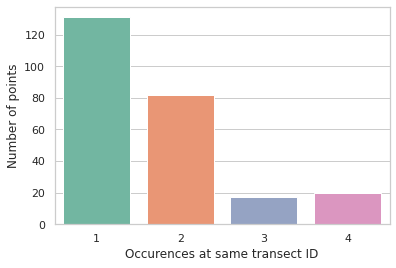

In [17]:
# plot occurences
ax = sns.countplot(x="Sum", data=df_joined, palette="Set2")
ax.set_ylabel('Number of points')
ax.set_xlabel('Occurences at same transect ID')

Text(0.5, 0, 'Occurences')

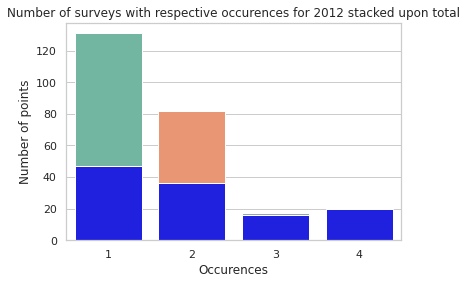

In [18]:
ax = sns.countplot(x="Sum", data=df_joined, palette="Set2")
ax.set_ylabel('Number of points')
ax.set_xlabel('Occurences at same transect ID')
# Let us replace the Boolean by the number of surveys which share a survey in the georaphic location
df_bool = df_joined.copy()
for i in range(4):
    df_joined.iloc[:,i] = df_joined.iloc[:,i]*df_joined['Sum']
df_joined_no_sum = df_joined.drop(columns = "Sum")   


ax = sns.countplot(x = 2012, data=df_joined_no_sum[-(df_joined_no_sum[2012] == 0)], color = "blue")
ax.set_title('Number of surveys with respective occurences for 2012 stacked upon total')
ax.set_ylabel('Number of points')
ax.set_xlabel('Occurences')

In [19]:
# Here I am taking the mean of the surveys, this was to check the mean per year, but be aware
# that I did not take into account spatial 
Survey_mean = Survey.groupby(["year"], as_index = False).mean()
Survey_mean

,year,surveyid,transectid,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,2012,12743.610169,12743.610169,-15.343183,146.132773,-15.342325,146.129333,0.220435,0.589255,0.074544,0.012550,0.103204
1,2014,32317.282209,27048.159509,-6.685382,133.586429,-6.685235,133.585799,0.176139,0.638571,0.046754,0.027002,0.111496
2,2016,44289.000000,16833.133333,-16.285364,146.371320,-16.283135,146.371235,0.188382,0.683850,0.052745,0.015107,0.059905
3,2017,47018.000000,13418.000000,-14.301355,145.098854,-14.298800,145.098036,0.156740,0.729780,0.056637,0.015174,0.041597
4,2018,64024.377778,32392.688889,-1.324658,119.060893,-1.324380,119.063982,0.170824,0.656802,0.031200,0.039582,0.101558


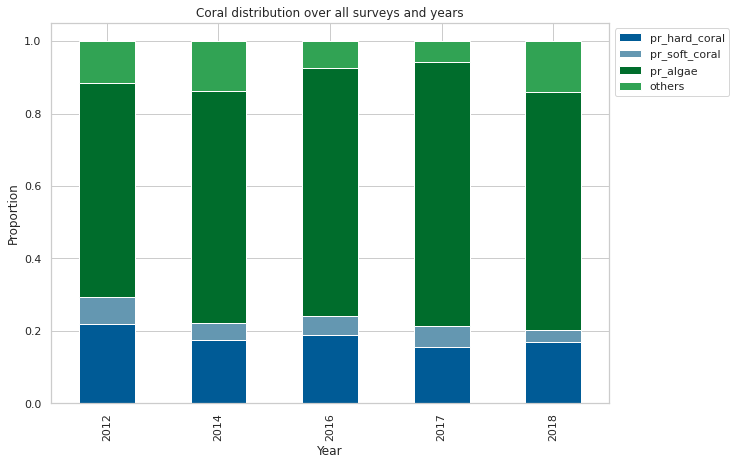

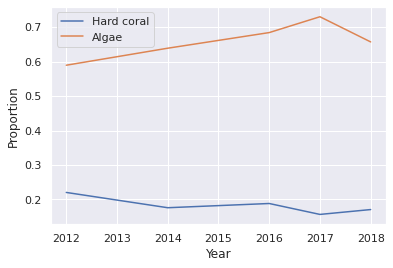

In [20]:
# Plot for mean 
pf.plot_mean_stack(Survey_mean, "Coral distribution over all surveys and years")
pf.hard_algae_plot(Survey_mean)

In [21]:
Survey_mean

,year,surveyid,transectid,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,others
0,2012,12743.610169,12743.610169,-15.343183,146.132773,-15.342325,146.129333,0.220435,0.589255,0.074544,0.012550,0.103204,0.115754
1,2014,32317.282209,27048.159509,-6.685382,133.586429,-6.685235,133.585799,0.176139,0.638571,0.046754,0.027002,0.111496,0.138498
2,2016,44289.000000,16833.133333,-16.285364,146.371320,-16.283135,146.371235,0.188382,0.683850,0.052745,0.015107,0.059905,0.075012
3,2017,47018.000000,13418.000000,-14.301355,145.098854,-14.298800,145.098036,0.156740,0.729780,0.056637,0.015174,0.041597,0.056771
4,2018,64024.377778,32392.688889,-1.324658,119.060893,-1.324380,119.063982,0.170824,0.656802,0.031200,0.039582,0.101558,0.141140


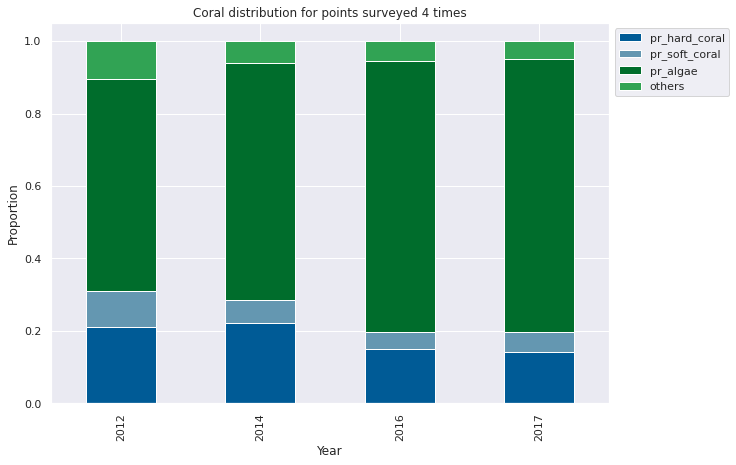

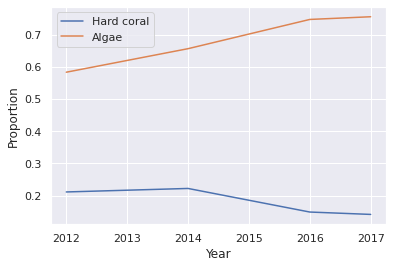

In [22]:
# This is the means for the regions that are the same 
df_4_region = pf.mean_region(Survey, df_joined, 4)
df_4 = df_4_region.groupby("year").mean()
pf.plot_mean_stack(df_4.reset_index(), "Coral distribution for points surveyed 4 times")
pf.hard_algae_plot(df_4)

Text(0, 0.5, 'Proportion')

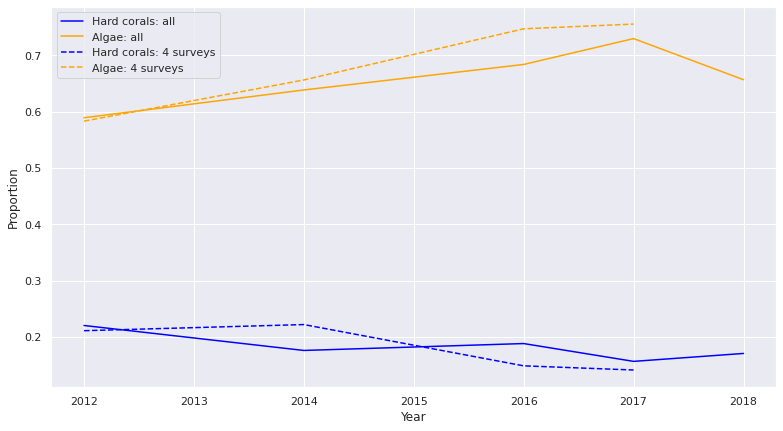

In [110]:
fig, ax = plt.subplots(figsize = (13,7))

ax.set_prop_cycle(color=['blue', 'orange', 'blue', 'orange'])
plt.plot(Survey_mean["year"], Survey_mean[["pr_hard_coral", "pr_algae"]], df_4.index, df_4[["pr_hard_coral", "pr_algae"]], '--')
#plt.plot(df_4.index, df_4[["pr_hard_coral", "pr_algae"]])
plt.legend(["Hard corals: all", "Algae: all", "Hard corals: 4 surveys", "Algae: 4 surveys"])
plt.xlabel("Year")
plt.ylabel("Proportion")

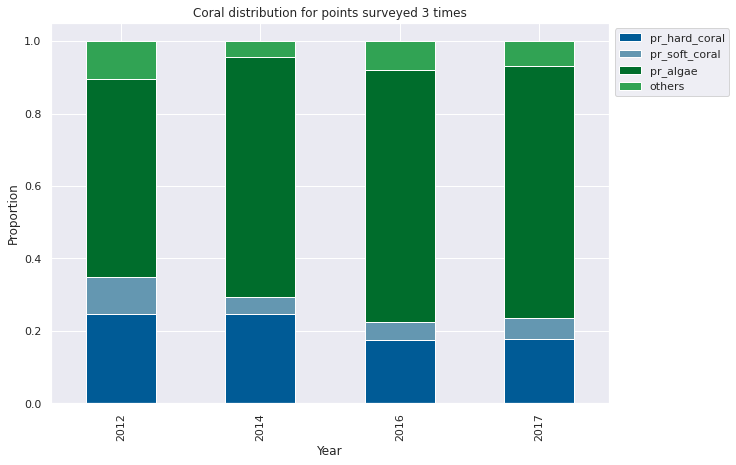

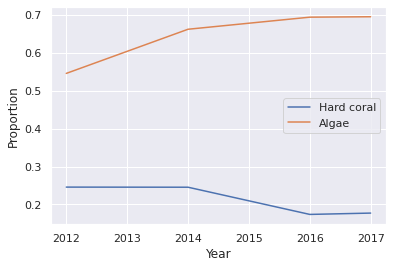

In [24]:
# This is the means for the regions that are the same 
df_3_region = pf.mean_region(Survey, df_joined, 3)
df_3 = df_3_region.groupby("year").mean()
pf.plot_mean_stack(df_3.reset_index(), "Coral distribution for points surveyed 3 times")
pf.hard_algae_plot(df_3)

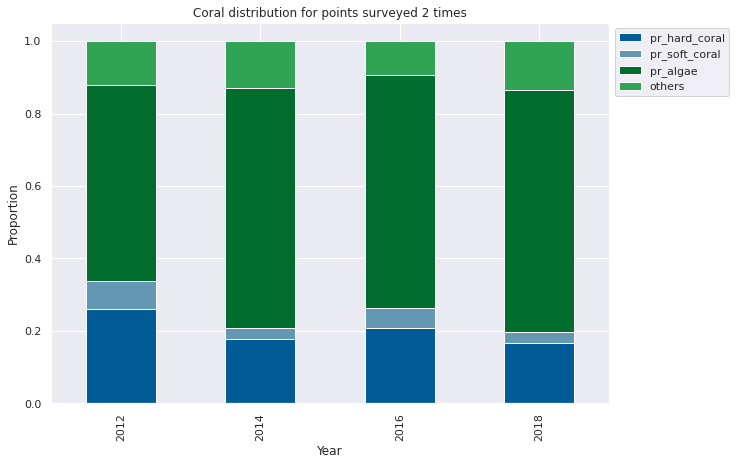

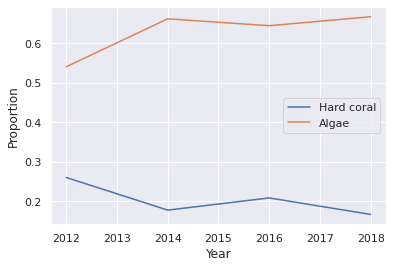

In [25]:
# This is the means for the regions that are the same 
df_2_region = pf.mean_region(Survey, df_joined, 2)
df_2 = df_2_region.groupby("year").mean()
pf.plot_mean_stack(df_2.reset_index(), "Coral distribution for points surveyed 2 times")
pf.hard_algae_plot(df_2.reset_index())

#### More insighful
It might be more insightful to look at the distribution of corals but within similar regions 



In [26]:
df_4_region = pf.make_geo_frame(df_4_region)
df_3_region = pf.make_geo_frame(df_3_region)


### Where are the corals 



<AxesSubplot:title={'center':'Continous survey locationsfor 4 years'}>

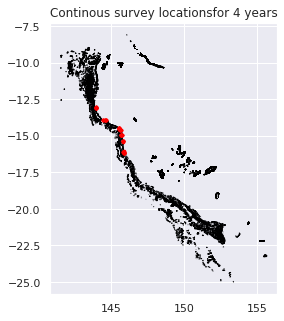

In [27]:
shx = gpd.read_file("../Data/Reefs/shp_GBR/Reefs_GBR.shx")
ax = shx.plot(figsize=(15, 5), edgecolor='black')
ax.set_title("Continous survey locationsfor 4 years")

# Plot the survey points on the GBR map
#gSurvey_2012.plot("pr_algea", ax = ax,color = "blue",markersize=7)
df_4_region.plot("pr_hard_coral", ax = ax,color = "red",markersize=7)


<AxesSubplot:title={'center':'Continous survey locations for 3 years'}>

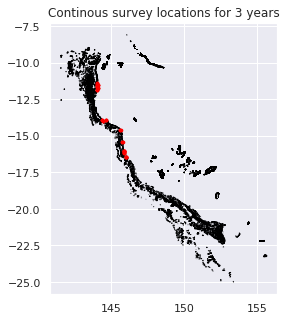

In [28]:
ax = shx.plot(figsize=(15, 5), edgecolor='black')
ax.set_title("Continous survey locations for 3 years")

df_3_region.plot("pr_hard_coral", ax = ax,color = "red",markersize=7)

### Australia 

Look at the difference in **Hard Corals** between 2017 and 2012 on same points

In [29]:
# retrieve transect id where you have surveys and for 2012 and for 2017
list_12_17 = df_bool.index[(df_bool[2012] == True) & (df_bool[2017] == True)].tolist()
print("You have ",len(list_12_17), " points where one survey was done in 2012 and another in 2017")

You have  34  points where one survey was done in 2012 and another in 2017


In [30]:
df_12 = pf.fun(gSurvey_2012,list_12_17)
df_17 = pf.fun(gSurvey_2017,list_12_17)

In [31]:
# Add the difference of hard coral and algae between 2017 qnd 2012 to dataframe 
# Add zero line
pf.group_others(df_17)
pf.group_others(df_12)

# Add others 
df_17["diff_hard"] = df_17["pr_hard_coral"] - df_12["pr_hard_coral"]
df_17["diff_algae"] = df_17["pr_algae"] - df_12["pr_algae"]
df_17["diff_others"] = df_17["others"] - df_12["others"]

In [32]:
df_diff_hard_AUS = df_17["diff_hard"]
df_diff_lat_AUS = df_17["geometry"].y

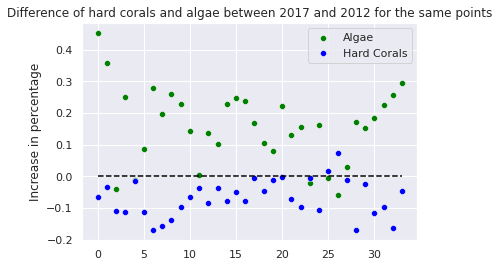

In [33]:
sns.scatterplot(y = df_17["diff_algae"], x = range(34),color="Green", label = "Algae")

ax = sns.scatterplot(y = df_17["diff_hard"], x = range(34), color = "Blue", label = "Hard Corals")
#ax = sns.scatterplot(y = df_17["diff_others"], x = range(34), color = "Red", label = "Others")
ax.set( xlabel = "", ylabel='Increase in percentage')
ax.set_title("Difference of hard corals and algae between 2017 and 2012 for the same points")
plt.plot(range(34), np.zeros(34),'--', color = "black")
plt.show()



## Spatial distribution of differences 
Next Goal: look at spatial distribution of regions depending on their difference of hard corals between 2012 and 2017, to note if some regions are more prone to decay than others



In [34]:
df_mean_hard = Survey.groupby("transectid").mean()["pr_hard_coral"]
df_mean_hard.rename("pr_mean_hard", inplace = True)

transectid
10001    0.210000
10002    0.180750
10003    0.180867
10004    0.124200
10005    0.078100
           ...   
41002    0.304000
41003    0.248300
41004    0.261900
41005    0.183900
41011    0.228400
Name: pr_mean_hard, Length: 245, dtype: float64

In [35]:
df_diff_mean = df_17.join(df_mean_hard, how = "inner")

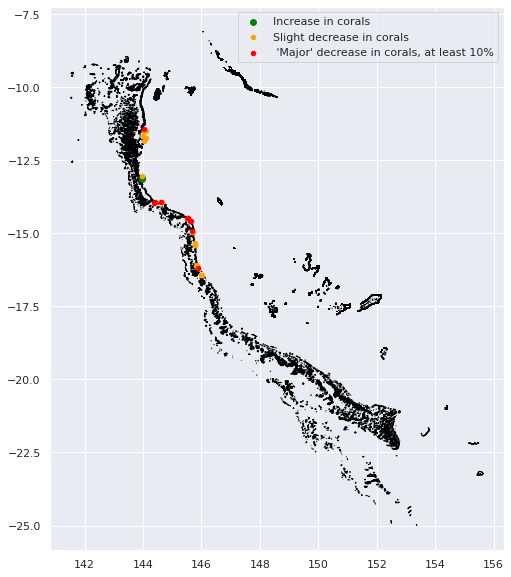

In [36]:

ax = shx.plot(figsize=(20, 10), edgecolor='black')

df_cor_increase = df_17[df_17["diff_hard"] >= 0]
df_cor_increase.plot(ax = ax, color = "green", markersize = 35, label = "Increase in corals")

df_minor_decrease = df_17[(df_17["diff_hard"] < 0) & (df_17["diff_hard"] > -0.1)]
df_minor_decrease.plot(ax =ax, color = "orange", markersize = 20, label = "Slight decrease in corals")

df_major_decrease = df_17[(df_17["diff_hard"] <= -0.1)]
df_major_decrease.plot(ax = ax, color = "red", markersize = 20, label = " 'Major' decrease in corals, at least 10%")


ax.legend();

In [37]:
df_lat = df_17.copy()
if ('lat'not in df_lat.columns):
    df_lat["lat"] = df_17["geometry"].y
    
df_lat["increase"] = df_lat["diff_hard"] >= 0
df_lat["slight_decrease"] = (df_17["diff_hard"] < 0) & (df_17["diff_hard"] > -0.1)
df_lat["major_decrease"] = (df_17["diff_hard"] <= -0.1)
df_lat.head()

,pr_hard_coral,pr_soft_coral,pr_algae,pr_oth_invert,pr_other,geometry,year,others,diff_hard,diff_algae,diff_others,lat,increase,slight_decrease,major_decrease
transectid,,,,,,,,,,,,,,,
10001,0.1192,0.0437,0.8253,0.0081,0.0037,POINT (145.89493 -16.19389),2017,0.0118,-0.0664,0.4529,-0.1592,-16.193885,False,True,False
10002,0.1038,0.0380,0.8329,0.0073,0.0179,POINT (145.89815 -16.18885),2017,0.0252,-0.0326,0.3563,-0.0539,-16.188854,False,True,False
10003,0.1385,0.0324,0.5264,0.0058,0.2968,POINT (145.89116 -16.17526),2017,0.3026,-0.1090,-0.0389,0.1902,-16.175264,False,False,True
12005,0.0591,0.0187,0.7207,0.0067,0.1945,POINT (145.61609 -14.57076),2017,0.2012,-0.1126,0.2504,-0.1470,-14.570760,False,False,True
12025,0.1717,0.0535,0.7665,0.0079,0.0001,POINT (145.56221 -14.50807),2017,0.0080,-0.0144,-0.0126,-0.0022,-14.508070,False,True,False


Text(0.5, 1.0, 'Change in corals between 2017-2012 based on latitude')

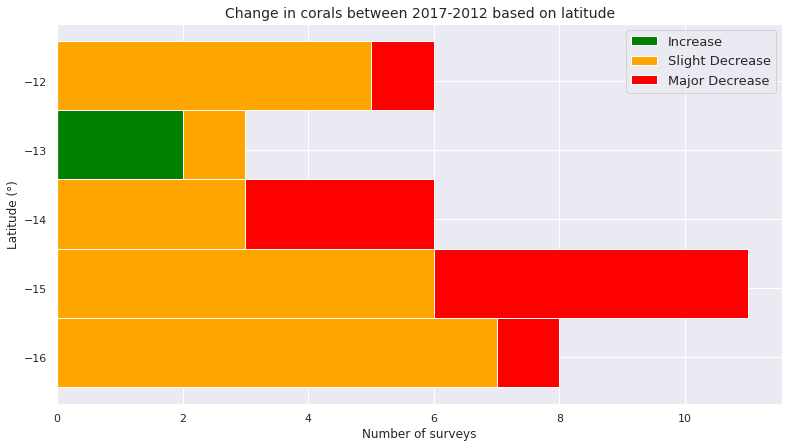

In [38]:

fig = plt.figure(figsize = (13,7))

h1 = fig.add_subplot()

bins = 5

h1.hist([df_lat[df_lat["increase"]]["lat"],df_lat[df_lat["slight_decrease"]]["lat"],df_lat[df_lat["major_decrease"]]["lat"]], bins=bins, stacked=True, orientation = "horizontal"\
       ,color = ("green", "orange", "red"));
plt.legend(["Increase", "Slight Decrease", "Major Decrease"], fontsize = 13)
plt.ylabel("Latitude (°)")
plt.xlabel("Number of surveys")
plt.title("Change in corals between 2017-2012 based on latitude", fontsize = 14)


**Labels**
Below -0.1 (“big” decrease in hard corals): Red dots
Between -0.1 and 0 (“medium decrease in hard corals”): Orange
Above 0 (“increase” in hard corals): Green dots

**Outcome**: We have an area of increase and medium decrease in the center of the zoomed mapped. A medium decrease in the North and some areas of more pronounced decrease in the South. What factors influence this ? → Will hopefully know using the anthropological and environemntal factors

**Next**: Do the same with the algae and then try to see what happens when you group by region instead

### Same with algae

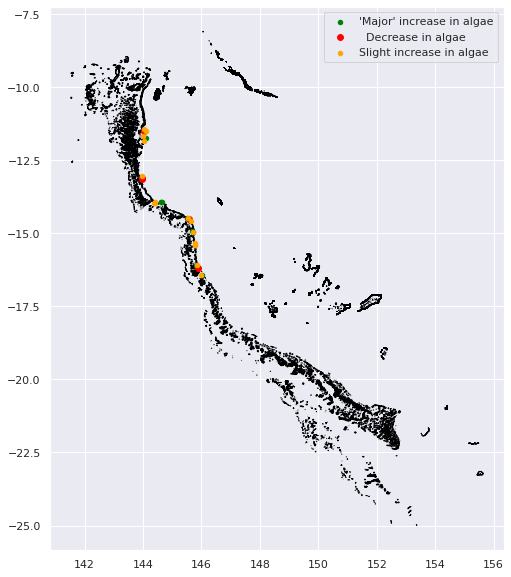

In [39]:

ax = shx.plot(figsize=(20, 10), edgecolor='black')


df_17[df_17["diff_algae"] >= 0.2].plot(ax = ax, color = "green", markersize = 20, label = "'Major' increase in algae")
df_17[(df_17["diff_algae"] <= 0)].plot(ax = ax, color = "red", markersize = 35, label = "  Decrease in algae")
df_17[(df_17["diff_algae"] > 0) & (df_17["diff_algae"] < 0.2)].plot(ax =ax, color = "orange", markersize = 20, label = "Slight increase in algae")
ax.legend()


In [40]:
df_lat["maj_increase_al"] = df_17["diff_algae"] >= 0.2
df_lat["slight_increase_al"] = (df_17["diff_algae"] > 0) & (df_17["diff_algae"] < 0.2)
df_lat["decrease_al"] = (df_17["diff_algae"] <= 0)

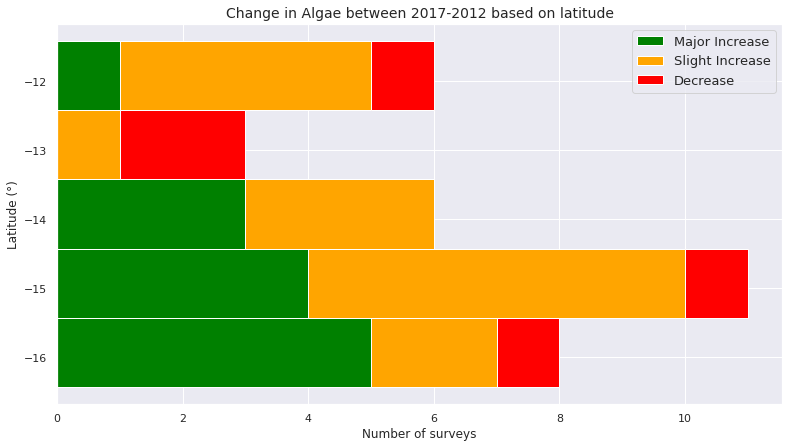

In [41]:
fig = plt.figure(figsize = (13,7))

h1 = fig.add_subplot()

bins = 5

h1.hist([df_lat[df_lat["maj_increase_al"]]["lat"],df_lat[df_lat["slight_increase_al"]]["lat"],df_lat[df_lat["decrease_al"]]["lat"]], bins=bins, stacked=True, orientation = "horizontal"\
       ,color = ("green", "orange", "red"));
plt.legend(["Major Increase", "Slight Increase", "Decrease"], fontsize = 13);
plt.ylabel("Latitude (°)")
plt.xlabel("Number of surveys")
plt.title("Change in Algae between 2017-2012 based on latitude", fontsize = 14);

In [42]:
df_lat.shape

(34, 18)

**Labels**
Above 0.2 (“big” increase in algae): Green dots
Between 0 and 0.2 (“medium increase in algae”): Orange
below 0 (Decrease in algae): Red dots


## Work on mapping 8May 

In [43]:
df_AUS = Survey[Survey["country"] == "AUS"]
#dp.geo_loads(df_AUS)
gdf_AUS = pf.make_geo_frame(df_AUS)

In [44]:
df_lat["decrease"] = df_lat["slight_decrease"] + df_lat["major_decrease"]

In [45]:
df_lat_inc = df_lat[df_lat["decrease"] == False]
df_lat_dec = df_lat[df_lat["decrease"] == True]

Text(0.5, 1.0, 'Mean coral cover in GBR 2012-2017')

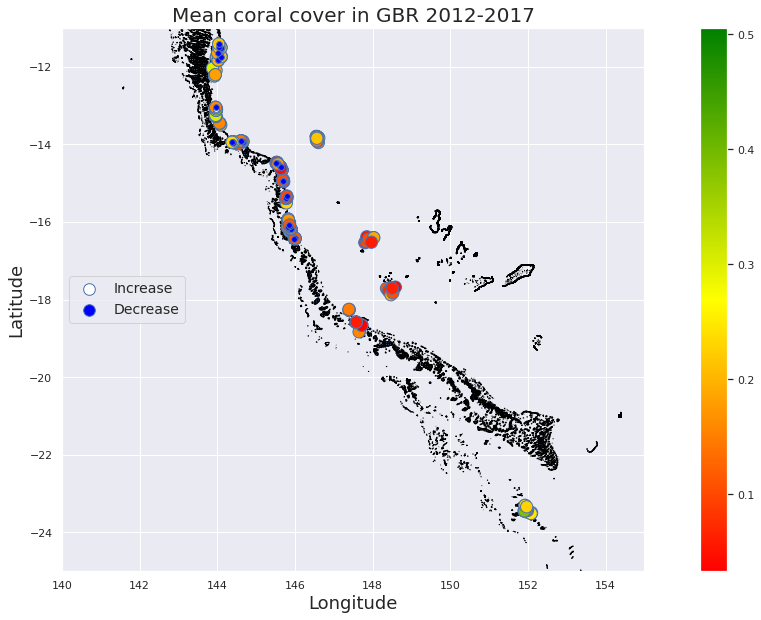

In [46]:

ax = shx.plot(figsize=(20, 10), edgecolor='black')
#df_diff_mean["pr_mean_hard"]
import matplotlib



cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])
gdf_AUS.plot("pr_hard_coral", ax = ax,  cmap = cmap, legend = True,markersize = 150,edgecolors='b')
#df_diff_mean.plot("pr_mean_hard", ax = ax, cmap = "RdYlGn", legend = True,markersize = 100)
df_lat_inc.plot("decrease", ax = ax, markersize = 34, label = "Increase",color = 'w',edgecolors='b')
df_lat_dec.plot("decrease", ax = ax, markersize = 34, label = "Decrease",color = 'blue',edgecolors='b')
plt.legend(loc = 'center left', fontsize = 14,markerscale = 2)

ax.set_xlim(140, 155)
ax.set_ylim(-25, -11)
plt.xlabel("Longitude", fontsize = 18)
plt.ylabel("Latitude", fontsize = 18)
plt.title("Mean coral cover in GBR 2012-2017", fontsize = 20)

### Doing the same with Indonesia since it has surveys both in 2014 and 2018

In [47]:

df_smart_ind_14 = pf.smart_df(Survey[(Survey["country"] == "IDN") & (Survey["year"] == 2014)], 2014)
df_smart_ind_18 = pf.smart_df(Survey[(Survey["country"] == "IDN") & (Survey["year"] == 2018)], 2018)

df_ind_diff = df_smart_ind_18.join(df_smart_ind_14, how = "outer").fillna(value = False)


In [48]:
list_ind = df_ind_diff.index[(df_ind_diff[2014] == True) & (df_ind_diff[2018] == True)].tolist()

In [49]:
nb_points = len(np.unique(list_ind))

In [50]:
print("We have ",nb_points, " points where surveys have been conducted twice")

We have  41  points where surveys have been conducted twice


In [51]:
df_14_ind = pf.fun(gSurvey_2014,list_ind).reset_index()
df_18_ind = pf.fun(gSurvey_2018,list_ind).reset_index()


In [52]:
# Group by trasnect and take the mean 
df_18_ind = df_18_ind.groupby('transectid').mean().reset_index()
df_14_ind = df_14_ind.groupby('transectid').mean().reset_index()

In [53]:
gSurvey_2018.drop_duplicates(subset = ["transectid"], inplace = True)

In [54]:
cols =  ["transectid", "geometry"]
df_18_ind = df_18_ind.merge(gSurvey_2018[cols], on = "transectid")

In [55]:
# Add the difference of hard coral and algae between 2017 qnd 2012 to dataframe 
# Add zero line
pf.group_others(df_18_ind)
pf.group_others(df_14_ind)

# Add others 
df_18_ind["diff_hard"] = df_18_ind["pr_hard_coral"] - df_14_ind["pr_hard_coral"]
df_18_ind["diff_algae"] = df_18_ind["pr_algae"] - df_14_ind["pr_algae"]
df_18_ind["diff_others"] = df_18_ind["others"] - df_14_ind["others"]

In [56]:
df_diff_hard_IND = df_18_ind["diff_hard"]
df_diff_lat_IND = df_18_ind["geometry"].y

In [57]:
df_18_ind = pf.make_geo_frame(df_18_ind)

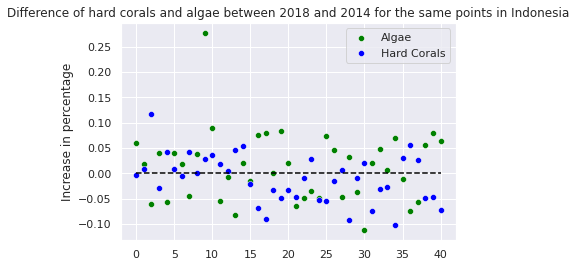

In [58]:
sns.scatterplot(y = df_18_ind["diff_algae"], x = range(nb_points),color="Green", label = "Algae")

ax = sns.scatterplot(y = df_18_ind["diff_hard"], x = range(nb_points), color = "Blue", label = "Hard Corals")
#ax = sns.scatterplot(y = df_17["diff_others"], x = range(34), color = "Red", label = "Others")
ax.set( xlabel = "", ylabel='Increase in percentage')
ax.set_title("Difference of hard corals and algae between 2018 and 2014 for the same points in Indonesia")
plt.plot(range(nb_points), np.zeros(nb_points),'--', color = "black")
plt.show()



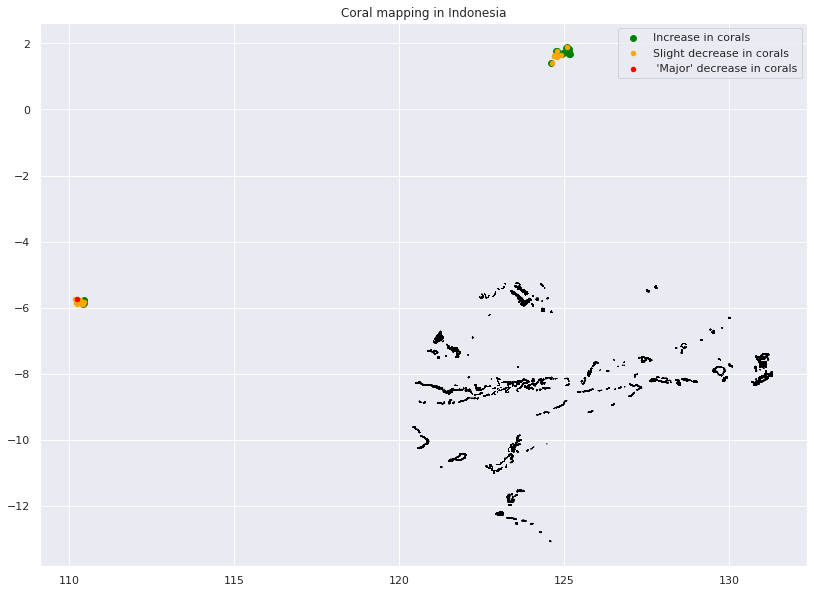

In [59]:
# Spatial distribution of Hard corals
shx = gpd.read_file("../Data/Reefs/shp_indonesia/indonesia.shx")
ax = shx.plot(figsize=(20, 10), edgecolor='black')

df_cor_increase_IND = df_18_ind[df_18_ind["diff_hard"] >= 0]
df_cor_increase_IND.plot(ax = ax, color = "green", markersize = 35, label = "Increase in corals")

df_minor_decrease_IND = df_18_ind[(df_18_ind["diff_hard"] < 0) & (df_18_ind["diff_hard"] > -0.1)]
df_minor_decrease_IND.plot(ax =ax, color = "orange", markersize = 20, label = "Slight decrease in corals")

df_major_decrease_IND = df_18_ind[(df_18_ind["diff_hard"] <= -0.1)]
df_major_decrease_IND.plot(ax = ax, color = "red", markersize = 20, label = " 'Major' decrease in corals")

ax.set_title("Coral mapping in Indonesia")
ax.legend();

In [60]:
df_lat_IND = df_18_ind.copy()
if ('lat'not in df_lat_IND.columns):
    df_lat_IND["lat"] = df_18_ind["geometry"].y
    
df_lat_IND["increase"] = df_lat_IND["diff_hard"] >= 0
df_lat_IND["slight_decrease"] = (df_18_ind["diff_hard"] < 0) & (df_18_ind["diff_hard"] > -0.1)
df_lat_IND["major_decrease"] = (df_18_ind["diff_hard"] <= -0.1)


Text(0.5, 1.0, 'Change in corals between 2018-2014 based on latitude in Indonesia')

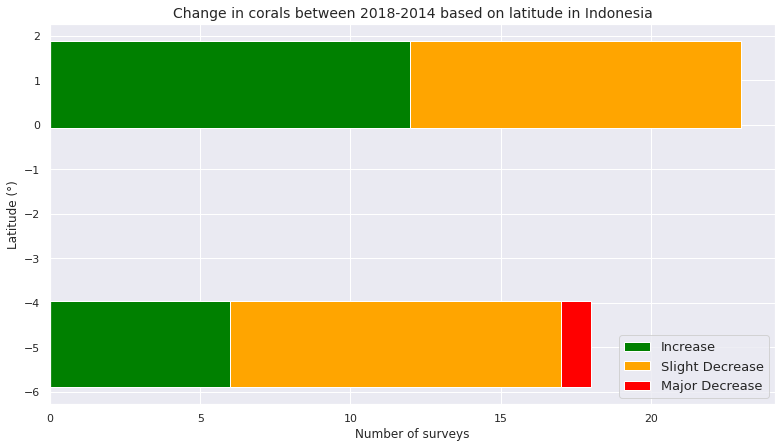

In [61]:

fig = plt.figure(figsize = (13,7))

h1 = fig.add_subplot()

bins = 4

h1.hist([df_lat_IND[df_lat_IND["increase"]]["lat"],df_lat_IND[df_lat_IND["slight_decrease"]]["lat"],df_lat_IND[df_lat_IND["major_decrease"]]["lat"]], bins=bins, stacked=True, orientation = "horizontal"\
       ,color = ("green", "orange", "red"));
plt.legend(["Increase", "Slight Decrease", "Major Decrease"], fontsize = 13)
plt.ylabel("Latitude (°)")
plt.xlabel("Number of surveys")
plt.title("Change in corals between 2018-2014 based on latitude in Indonesia", fontsize = 14)


### Same with algae

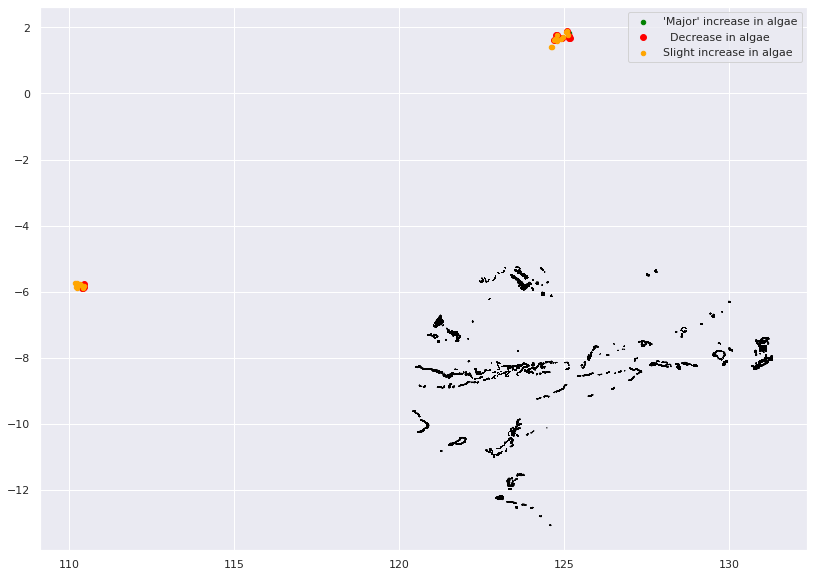

In [62]:

ax = shx.plot(figsize=(20, 10), edgecolor='black')


df_18_ind[df_18_ind["diff_algae"] >= 0.2].plot(ax = ax, color = "green", markersize = 20, label = "'Major' increase in algae")
df_18_ind[(df_18_ind["diff_algae"] <= 0)].plot(ax = ax, color = "red", markersize = 35, label = "  Decrease in algae")
df_18_ind[(df_18_ind["diff_algae"] > 0) & (df_18_ind["diff_algae"] < 0.2)].plot(ax =ax, color = "orange", markersize = 20, label = "Slight increase in algae")
ax.legend()


In [63]:
df_lat_IND["maj_increase_al"] = df_18_ind["diff_algae"] >= 0.2
df_lat_IND["slight_increase_al"] = (df_18_ind["diff_algae"] > 0) & (df_18_ind["diff_algae"] < 0.2)
df_lat_IND["decrease_al"] = (df_18_ind["diff_algae"] <= 0)

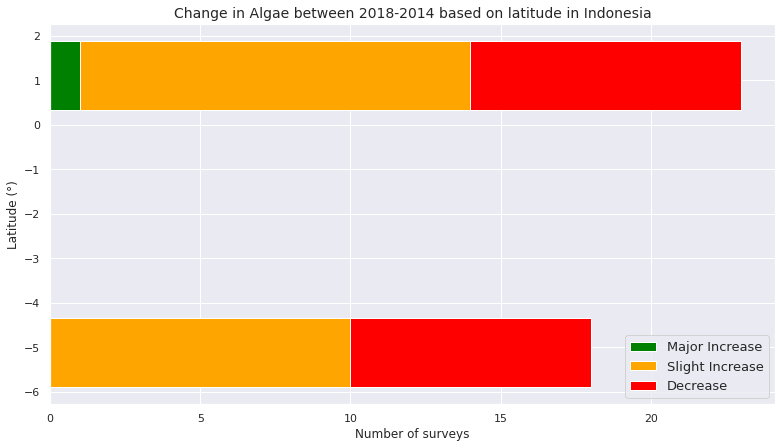

In [64]:
fig = plt.figure(figsize = (13,7));

h1 = fig.add_subplot();

bins = 5

h1.hist([df_lat_IND[df_lat_IND["maj_increase_al"]]["lat"],df_lat_IND[df_lat_IND["slight_increase_al"]]["lat"],df_lat_IND[df_lat_IND["decrease_al"]]["lat"]], bins=bins, stacked=True, orientation = "horizontal"\
       ,color = ("green", "orange", "red"));
plt.legend(["Major Increase", "Slight Increase", "Decrease"], fontsize = 13);
plt.ylabel("Latitude (°)")
plt.xlabel("Number of surveys")
plt.title("Change in Algae between 2018-2014 based on latitude in Indonesia", fontsize = 14);

### Combine with Australia depending on latitude

**For Corals**

In [65]:
df_lat_IND.shape


(41, 19)

In [66]:
df_increase_PAC = df_lat[df_lat["increase"]]["lat"].to_list() + df_lat_IND[df_lat_IND["increase"]]["lat"].to_list()
df_slight_decrease_PAC = df_lat_IND[df_lat_IND["slight_decrease"]]["lat"].to_list() + df_lat[df_lat["slight_decrease"]]["lat"].to_list()
df_major_decrease_PAC = df_lat_IND[df_lat_IND["major_decrease"]]["lat"].to_list() + df_lat[df_lat["major_decrease"]]["lat"].to_list()

In [67]:
len(df_increase_PAC) + len(df_slight_decrease_PAC) + len(df_major_decrease_PAC)

75

Text(0.5, 1.0, 'Change in corals through 2012 and 2018 in the Pacific')

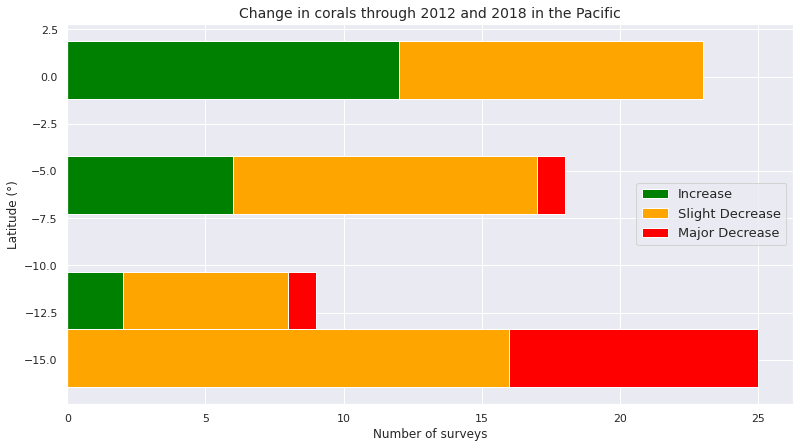

In [68]:
fig = plt.figure(figsize = (13,7))

h1 = fig.add_subplot()

bins = 6

h1.hist([df_increase_PAC,df_slight_decrease_PAC,df_major_decrease_PAC], bins=bins, stacked=True, orientation = "horizontal"\
       ,color = ("green", "orange", "red"));
plt.legend(["Increase", "Slight Decrease", "Major Decrease"], fontsize = 13)
plt.ylabel("Latitude (°)")
plt.xlabel("Number of surveys")
plt.title("Change in corals through 2012 and 2018 in the Pacific", fontsize = 14)


In [69]:
df_major_decrease_PAC

[-5.7518080000000005,
 -16.175264000000002,
 -14.57076,
 -14.471767999999999,
 -14.477213,
 -14.589404,
 -14.936460999999998,
 -11.419689,
 -13.942835999999998,
 -13.949991,
 -13.919872]

**For algae**

In [70]:
df_maj_PAC = df_lat_IND[df_lat_IND["maj_increase_al"]]["lat"].to_list() + df_lat[df_lat["maj_increase_al"]]["lat"].to_list()
df_inc_PAC = df_lat_IND[df_lat_IND["slight_increase_al"]]["lat"].to_list() + df_lat[df_lat["slight_increase_al"]]["lat"].to_list()
df_decr_PAC =df_lat_IND[df_lat_IND["decrease_al"]]["lat"].to_list() + df_lat[df_lat["decrease_al"]]["lat"].to_list()

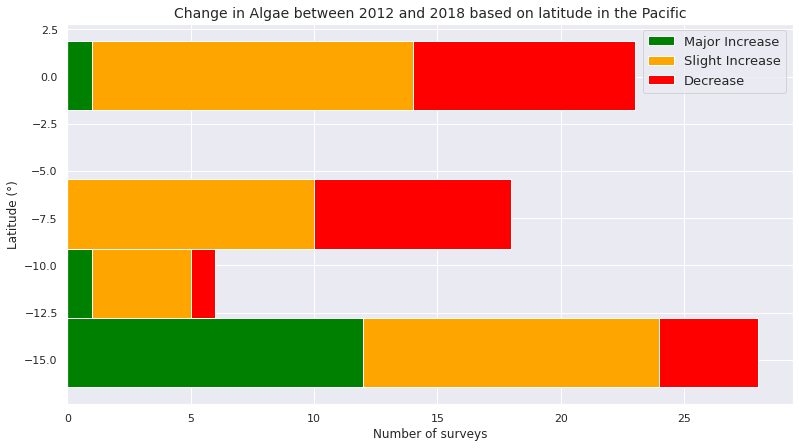

In [71]:
fig = plt.figure(figsize = (13,7))

h1 = fig.add_subplot()

bins = 5

h1.hist([df_maj_PAC, df_inc_PAC,df_decr_PAC], bins=bins, stacked=True, orientation = "horizontal"\
       ,color = ("green", "orange", "red"));
plt.legend(["Major Increase", "Slight Increase", "Decrease"], fontsize = 13);
plt.ylabel("Latitude (°)")
plt.xlabel("Number of surveys")
plt.title("Change in Algae between 2012 and 2018 based on latitude in the Pacific", fontsize = 14);

## Separation between North and South in Pacific
Looking at the last graph it would be interesting to separate North and South at a latitude of about -10



In [72]:
Survey_geo = pf.make_geo_frame(Survey)
Survey_geo["lat"] = Survey_geo.geometry.y

Survey_mean_North = Survey_geo[Survey_geo["lat"] >= -13.5].groupby(["year"], as_index = False).mean()
Survey_mean_South = Survey_geo[Survey_geo["lat"] < -13.5].groupby(["year"], as_index = False).mean()
Survey_mean_North.set_index("year", inplace = True)
Survey_mean_South.set_index("year", inplace = True)
Survey_mean_North["others"] = Survey_mean_North["pr_oth_invert"] + Survey_mean_North["pr_other"]
Survey_mean_South["others"] = Survey_mean_South["pr_oth_invert"] + Survey_mean_South["pr_other"]
Survey_mean_North.drop(columns = ['surveyid', 'transectid', 'lat_start', 'lng_start', 'lat_end',
       'lng_end', 'lat', "pr_oth_invert", "pr_other"], inplace = True)
Survey_mean_South.drop(columns = ['surveyid', 'transectid', 'lat_start', 'lng_start', 'lat_end',
       'lng_end', 'lat',"pr_oth_invert", "pr_other"], inplace = True)
cols = ['pr_hard_coral',  'pr_soft_coral', 'pr_algae','others']
Survey_mean_South = Survey_mean_South[cols]
Survey_mean_North = Survey_mean_North[cols]
#Survey_mean_South.drop(columns = ['pr_hard_coral', 'pr_algae', 'pr_soft_coral', 'lat', 'others'], inplace = True)

In [73]:
s = Survey_mean_South.xs(2014)

s.name = 2018

In [74]:
Survey_mean_South = Survey_mean_South.append(s)
Survey_mean_South.loc[2018] = 0

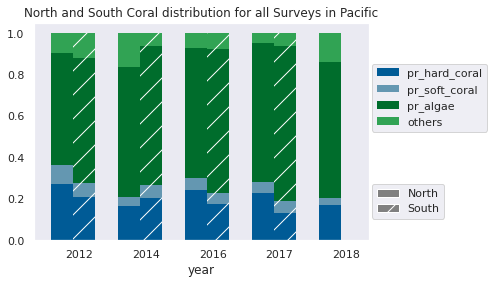

In [75]:
def plot_clustered_stacked(dfall, labels=None, title="North and South Coral distribution for all Surveys in Pacific",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)
    

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs,
                     color = ["#005b96","#6497b1","#006D2C", "#31A354","#31A354"])  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe


# Then, just call :
plot_clustered_stacked([Survey_mean_North, Survey_mean_South],["North", "South"]);

### Do a statistical test for checking if significant result between latitude and difference in hard corals. 

In [76]:
df = pd.DataFrame()

In [77]:
df["lat"] = df_diff_lat_AUS.append(df_diff_lat_IND)

In [78]:
df["diff_hard"] = df_diff_hard_AUS.append(df_diff_hard_IND)

In [79]:
df["index"] = np.arange(75)

In [80]:
df.set_index("index", inplace = True)

In [83]:
import scipy.stats as stats

stats.f_oneway(df['diff_hard'][df['lat'] > -2.5],
               df['diff_hard'][(df['lat'] <= -2.5) &(df['lat'] > -7.5)],
               df['diff_hard'][(df['lat'] <= -7.5) & (df['lat'] > -13)],
              df['diff_hard'][df['lat'] <= -13])

F_onewayResult(statistic=8.296168765814665, pvalue=8.361318085657811e-05)